In [380]:
# This notebook looks into how existing vanilla transformers do math
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))  # Adjust width and height as needed


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [381]:
# ----- dependencies
if False:
    !pip install transformers 
    #!pip install git+https://github.com/huggingface/transformers #accelerate deepspeed
    !pip install -U huggingface_hub
    !pip install -U accelerate
    !pip install --upgrade pip
    !pip install torch

    # ----- dependencies
    import os
    import torch
    from transformers import LlamaModel, LlamaConfig, LlamaForCausalLM
    from huggingface_hub import login
    import torch.optim as optim
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

In [382]:

# ----- HYPERPARAMETERS
LLM_context_length = 20 
LLM_hid =      384
LLM_layers =   4
LLM_n_heads =  12

# --- training
batch_size = 256
iterations = 10000
epochs = 1





# --- character-level tokenizer
class Char_Tokenizer():

    def __init__(self):
        self.chars = ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9','+','=',' ']
        self.bos_token=1
        self.eos_token=2
        self.pad_token=0
        self.vocab_size = len(self.chars)
        self.char2idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx2char = {i: ch for i, ch in enumerate(self.chars)}

    def tokenize(self, text, max_length=None):
        list = [self.char2idx[ch] for ch in text]
        list.insert(0,self.bos_token) # prefix <s>
        list.append(self.eos_token) # suffix </s>
        if max_length is None:
            return list
        else: # padding/cropping if max length is specified
            list += [self.pad_token for i in range(max(0,max_length-len(list)))]
            list = list[0:max_length]
            return list
    
    def detokenize(self, ids):
        return "".join([self.idx2char[i] for i in ids])
    
tokenizer = Char_Tokenizer()
vocab_size = tokenizer.vocab_size



In [383]:
# -------------- define and initialize nano GPT model
pre_ln = 0
post_ln = 0
post_MLP = 0
four = 0
one = 0

""" Nano-GPT:

Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))
    def forward(self, x):
        #print('att x',x.mean(), x.max())
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        #plt.imshow(k[0].detach().cpu().numpy())
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        #plt.show()
        #print('key',k.mean(),k.min(),k.max())
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        #print('KQ diff',(k-q).mean(), (k-q).max(), (k-q).min())
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        #print('v', v.mean(), v.max())

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att_map = att.detach().clone()
        att = self.attn_dropout(att)
        #print('att weight',att.mean(), att.max())
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, att_map

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.ReLU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        #print(x.mean(), x.std(), x.min(), x.max())
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module): # ================================================================================ printblock

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        print('==================== MLP ===================')
        global one, two, three, four, five
        ln = self.ln_1(x)
        att, att_map = self.attn(ln)
        x = x + att

        #plt.imshow(x[0].detach().cpu().numpy())
        #plt.show()
        #plt.plot(x[0,3].detach().cpu().numpy())
        #plt.show()
        one = x.detach().clone()
        #print('pre-MLP-nor residual^', x[0].mean(), x[0].std(),  x[0].max(), x[0].min())


        pre_mlp = self.ln_2(x)
        plt.figure(figsize=(20, 20))  # Adjust width and height as needed
        plt.imshow(pre_mlp[0].detach().cpu().numpy(), interpolation='nearest')
        plt.show()
        plt.figure(figsize=(5, 5)) 
        plt.plot(pre_mlp[0,3].detach().cpu().numpy())
        plt.show()
        pre_mlp_ = pre_mlp.detach().clone()
        two = pre_mlp_
        print('normalized MLP input^', pre_mlp[0].mean(), pre_mlp[0].std(),  pre_mlp[0].max(), pre_mlp[0].min())

        mlp = self.mlp(pre_mlp)
        three=mlp
        #plt.figure(figsize=(10, 10))  # Adjust width and height as needed
        #plt.imshow(mlp[0].detach().cpu().numpy())
        #plt.show()
        #plt.plot(mlp[0,3].detach().cpu().numpy())
        #plt.show()
        #print('MLP output^', mlp[0].mean(), mlp[0].std(),  mlp[0].max(), mlp[0].min())

        x = x + mlp
        four=x
        plt.figure(figsize=(20, 20))  # Adjust width and height as needed
        plt.imshow(x[0].detach().cpu().numpy(), interpolation='nearest')
        plt.show()
        plt.figure(figsize=(5, 5)) 
        plt.plot(x[0,3].detach().cpu().numpy())
        plt.show()
        print('MLP+residual output^', x[0].mean(), x[0].std(),  x[0].max(), x[0].min())

        #plt.figure(figsize=(10, 10))  # Adjust width and height as needed
        #plt.imshow(x[0].detach().cpu().numpy()>4)
        #plt.show()
        #print('5',x.mean(), x.std(), x.min(), x.max())
        print('\n\n\n')
        return x, att_map, pre_mlp_

@dataclass
class GPTConfig:
    block_size: int = 256
    vocab_size: int = tokenizer.vocab_size # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 6
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        att_maps=()
        hidden_states=()
        print('--- hidden 0',x.mean(), x.std(), x.min(), x.max())
        for block in self.transformer.h:
            x, att_map, pre_mlp = block(x)
            att_maps += (att_map.clone(),)
            hidden_states += (pre_mlp.detach().clone(),)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss, att_maps, hidden_states

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

config = GPTConfig(
        block_size = LLM_context_length,
        vocab_size = tokenizer.vocab_size, # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
        n_layer = LLM_layers,
        n_head = LLM_n_heads,
        n_embd = LLM_hid,
        dropout = 0.2,
        bias = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
        )

model = GPT(config)
model.eval()

number of parameters: 7.09M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(16, 384)
    (wpe): Embedding(20, 384)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): ReLU()
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=16, bias=False)
)

In [384]:
# data generator
import random
eval_pairs = []
for i in range((2000//batch_size)*batch_size):
    eval_pairs.append((random.randint(0, 999), random.randint(0, 999)))
len(eval_pairs)



def batch(batch_size, ctx):
    
    # get batch x, y
    batch_input_ids = torch.zeros([batch_size,ctx],dtype=torch.long)
    for b_idx in range(batch_size):
        num1,num2=eval_pairs[0]
        while ((num1,num2) in eval_pairs) or ((num2,num1) in eval_pairs):            
            num1 = random.randint(0, 999)
            num2 = random.randint(0, 999)
        result = str(num1 + num2)
        problem = f"{num1}+{num2}={result}"
        tokenized = tokenizer.tokenize(problem, max_length=ctx)
        batch_input_ids[b_idx][:] = torch.tensor(tokenized)
    labels = batch_input_ids.clone()
    labels[labels==tokenizer.pad_token] = -100

    return batch_input_ids, labels

12 32
tensor(1.)
tensor(1.)


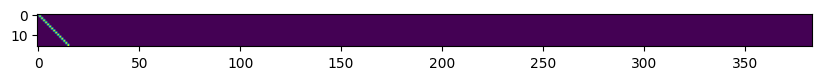

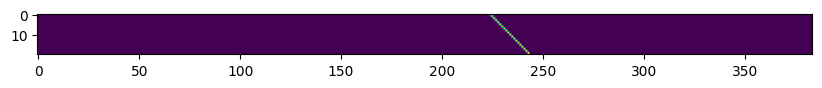

In [385]:
# edit embeddings to give each number a corresponding 1-hot
# ['<pad>','<s>','</s>','0','1','2','3','4','5','6','7','8','9', '+','=',' ']
#   0        1      2    3   4   5  6    7   8   9   10  11  12  13  14  15

# edit learnt positional embedding. Since this is just added to the embedding, we can edit the equivalent location of head 2 here with a positional embedding encoded in binary
head_size = LLM_hid//LLM_n_heads
print(LLM_n_heads, head_size)


# assign neurons to digits 0-9
import numpy as np
model.transformer.wte.weight.data[:] = 0
model.transformer.wte.weight.data[:16, :16] = torch.eye(16,16)
#model.transformer.wte.weight.data[:,head_size*5:head_size*6] = 1

# creating a pos/neg spike in all embeddings survives normalization and can be used as a bias
#model.transformer.wte.weight.data[:,-1] = .1
#model.transformer.wte.weight.data[:,-2] = -.1

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(model.transformer.wte.weight.data)








model.transformer.wpe.weight.data[:] = 0
for i in range(min(head_size, LLM_context_length)):
    model.transformer.wpe.weight.data[i, head_size*7+i] = 1
    model.transformer.wpe.weight.data[i, head_size*7+21:head_size*8] = 0 #4.7

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(model.transformer.wpe.weight.data)



wte = model.transformer.wte.weight.data
wpe=model.transformer.wpe.weight.data
print(wpe.max())
print(wte.max())

In [386]:

# ALGORITHM:
# layer 0 att: 
#   head 1: word embeddings - identity mapping
#   head 2: attend to all past words. Future MLP layer can look at this and see what tokens have been seen
#   head 3: num1 digit positions - identity |
#   head 4: num2 digit positions - identity |-- these store the positions of digits in a way we can find them later
#   head 5: tracked num 1 digit
#   head 6: tracked num 2 digit
#   head 7: encoding of the result calculated so far - unlike with CoT, the entire calculation must be done in 1 hidden state. we obviously cant dedicate the entire hidden state to it (without polysemanticity but thats messy and hard) so we dedicate a subsection - this attention head.
#   head 8: positional embeddings - identity
#   head 9: num 1 current tracking digit position  |
#   head 10: num 2 current tracking digit position  |--- these two allow the addresses of the target digits to be stored and incremented across the layers
#   head 11: num 1 current tracking digit
#   head 12: num 2 current tracking digit

# layer 0: 
#               always remove info from residual stream - set to max value
#
#               if head 1 is digit AND NOT + in head 2:
#                       read head 3 position. if head3==0, do nothing. if head3>0, output head3+1. set head 4 to 0
#               if head 1 is digit AND + head 2, get token distance from + add this positional encoding to head 4. 
#               if head 1 is = set head 6 to current positional embedding -1. else set head 6 to current positional embedding.  (implement this every layer. therefore, at = sign, head 6 wil go up num 2 positional embeddings)
#              
#
# layer 1 att: 
#   head 1: 
#   head 2: 
#   head 3:
#
#   head 5: only active during = token. after = token shows, this outputs the latest positional encoding of 
#   head 6

# layer 1 MLP: 
#
#   head5: input is the positional encoding of the latest num1 digit (actually, the sum of all of them, which can be used to identify the max). output is the positional encoding of the previous num1 digit on head5 and the sum operation with head5,head6,head7 onto head7
#   head6: input is the positional encoding of the latest num2 digit (actually, the sum of all of them, which can be used to identify the max). output is the positional encoding of the previous num1 digit on head6 and the sum operation with head5,head6,head7 onto head7

#   

In [387]:
# INITIALIZE ATTENTION LAYERS AS IDENTITY

# make attention close to identity - we just want to pass tokens forward. for this, make all heads output head 2 (position head) as the query and key, and leave value as identity
for i in range(LLM_layers):

    # c_attn is of shape [embed_dim*3, embed_dim]. the first [0:embed_dim, :] corresponds to the weights mapping the embed to the key heads, all [num_heads] of which are spread across this

    # --- query heads
    # init queries to 0
    model.transformer.h[i].attn.c_attn.weight.data[0:LLM_hid,             :] = 0 
    # map all queries  to correspond to head 8 - positional embedding. this way all queries pay most attention to their respective key from the same token column/position.
    id_zeros = torch.eye(head_size,head_size)
    id_zeros[20:, 20:] = 0
    id_zeros[20:, 20] = 1
    model.transformer.h[i].attn.c_attn.weight.data[0:LLM_hid,             head_size*7:(head_size*8)] = id_zeros.repeat(LLM_n_heads,1)  





    # --- key heads
    # init keys to 0
    model.transformer.h[i].attn.c_attn.weight.data[LLM_hid:LLM_hid*2,      :] = 0 
    # map all key outputs to correspond to head 8 - positional embedding. this way all queries pay most attention to their respective key from the same token column
    model.transformer.h[i].attn.c_attn.weight.data[LLM_hid:LLM_hid*2,      head_size*7:(head_size*8)] = id_zeros.repeat(LLM_n_heads,1)

    



    # --- value heads
    model.transformer.h[i].attn.c_attn.weight.data[LLM_hid*2:LLM_hid*3,    :] = torch.eye(LLM_hid,LLM_hid) # set embed->values to identity


    # --- output projection
    model.transformer.h[i].attn.c_proj.weight.data[:] = torch.eye(LLM_hid,LLM_hid) # set output projection as identity






In [388]:
# because of residual & LayerNorm, either setting MLPs to identity or all 0 results in identity
# --- REMOVE RESIDUAL STREAM INFO

for i in range(LLM_layers):
    model.transformer.h[i].mlp.c_fc.weight.data[:] = 0
    model.transformer.h[i].mlp.c_proj.weight.data[:] = 0

In [389]:
# edit MLP 1 to provide positional encoding to each digit

# --- remember that the input/output is normalized and no biases, and has residual











#MLP NEURONS USE
#  -- HIDDEN LAYER
# 0:hid = [identity];     256 = '+' detector;   hid+headSize:hid+headSize*2=[identity head8, downweight +]   hid*3:hid*4 = [identity];    
#  -- LAYER ONE
# 0:hid,0:hid - identity
# -- LAYER TWO



# MLP 1 gives digits positional embeddings
# MLP 2 sums these digit positional embeddings so we can count how many digits there are and creates digit positional embeddings representing the last positions
# MLP 3 - this MLP - counts backwards from the initial positional embedding count






# ====================================================================  LAYER 1: ADD PER-NUMBER DIGIT POSITIONAL EMBEDDING


# ======================= ATTENTION 0
# make head 2 output sum word tokens past
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size:LLM_hid*2+head_size*2,      :] = 0
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size:LLM_hid*2+head_size*2,      0:head_size] = torch.eye(head_size,head_size)

# make head5 identity of token embedding digit at coresponding posiition
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size*4:LLM_hid*2+head_size*5,      :] = 0
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size*4:LLM_hid*2+head_size*5,      0:head_size] = torch.eye(head_size,head_size)
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size*5:LLM_hid*2+head_size*6,      :] = 0
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid*2+head_size*5:LLM_hid*2+head_size*6,      0:head_size] = torch.eye(head_size,head_size)

# - provide each digit with a positional embedding according to its position in each number. use different head for the different numbers
# make head 2 pay attention to all past head1 q
model.transformer.h[0].attn.c_attn.weight.data[head_size:head_size*2,             :] = 0
# make head 2 pay attention to all past head1 # k
model.transformer.h[0].attn.c_attn.weight.data[LLM_hid+head_size:LLM_hid+head_size*2,      :] = 0


# =========================  MLP 0
model.transformer.h[0].mlp.c_fc.weight.data[:] = 0
model.transformer.h[0].mlp.c_proj.weight.data[:] = 0
model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid*3:LLM_hid*4, :] = torch.eye(LLM_hid,LLM_hid)
model.transformer.h[0].mlp.c_proj.weight.data[:, LLM_hid*3:LLM_hid*4] = torch.eye(LLM_hid,LLM_hid) *- 1.5
# layer norm may set the minimum value to below 0 - this messes with relu. We can reverse this by detecting the negative value using the unused bits of positional encoding and add the negative of these to all hidden layer neurons
model.transformer.h[0].mlp.c_fc.weight.data[:, head_size*7+30] = -1


# --- create identity map for head 1 word embedding
for l in range(LLM_layers):
    model.transformer.h[l].mlp.c_fc.weight.data[:head_size, :head_size] = torch.eye(head_size, head_size)
    model.transformer.h[l].mlp.c_proj.weight.data[:head_size, :head_size] = torch.eye(head_size, head_size)*1.4

# --- create identity map for head 6 norm control
#for l in range(LLM_layers):
#    model.transformer.h[l].mlp.c_fc.weight.data[head_size*5:head_size*6, head_size*5:head_size*6] = torch.eye(head_size, head_size)
#    model.transformer.h[l].mlp.c_proj.weight.data[head_size*5:head_size*6, head_size*5:head_size*6] = torch.eye(head_size, head_size)

# --- attention layer 0 sums history of tokens. MLP 0 uses these to detect when to assign positional embeddings to different digits. They are removed by the residual

# --- attention layer 0 copies word embeddings from head1 to heads 5,6 for use as biases

# --- create identity map for head 8 positional embedding
model.transformer.h[0].mlp.c_fc.weight.data[head_size*7:head_size*8,    head_size*7:head_size*8] = torch.eye(head_size, head_size)
model.transformer.h[0].mlp.c_proj.weight.data[head_size*7:head_size*8,    head_size*7:head_size*8] = torch.eye(head_size, head_size)*1.4


# create a way to remove the residual stream 
# given the residual and layernorm, we need to have the MLP output the inverse of that signal to zero it out. unfortunately, we cannot take the negative because ReLU only allows positive outputs
# however, given layernorm, we can have the MLP output neurons output the 




# -- num1 digit position tracker
# 1. create neuron to check for + symbol at any time in past
model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid, head_size+13] = 1  # hidden neuron #head_size activates to supress. We want on/off, so we let it output 
if True:
    # 2.  project head8 into hidden
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size:LLM_hid+head_size*2,    head_size*7:head_size*8] = torch.eye(head_size, head_size)

    # downweight head8proj by + appearing in head 2 (i.e. anywhere in context). this incidentaly upweights when = is not present
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size:LLM_hid+head_size*2,    head_size+13] = -22

    # counteract upweight - always downweight head8hidden2 with a bias (we use head5 as a bias since exactly 1 of its neurons is guaranteed to be a 1, and this way we dont interfere with connection from head8 or head1, which could euqally be used as a bias for the same reason)
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size:LLM_hid+head_size*2,    head_size*4:head_size*5] = -0.5

    # project head8hidden to head3 output
    model.transformer.h[0].mlp.c_proj.weight.data[head_size*2:head_size*3,    LLM_hid+head_size:LLM_hid+head_size*2] = torch.eye(head_size, head_size)*1.4
    # 4. but also make all head 3 output neurons depend on the '+' neuron so they stop outputting once this is active. CATCH - 
    #   we can assign negative weights from + neuron to head3 neurons, but because we are using relu, the best this can do is set the output to 0,
    #   and bc LayerNorm, we end up with identity. What we want is the output MLP to have head3 all negative. we can do this by having it so that when there is a +, the + neuron adds a high value to all neurons except head 3. Layernorm will center it and force head3 to become negative.

# -- num2 digit position tracker
if True:

    # 2.  project head8 into new area of hidden (head8hidden2)
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size*2:LLM_hid+head_size*3,    head_size*7:head_size*8] = torch.eye(head_size, head_size)*2
    
    # always downweight head8hidden2 with a bias (we use head5 as a bias since exactly 1 of its neurons is guaranteed to be a 1, and this way we dont interfere with connection from head8 or head1, which could euqally be used as a bias for the same reason)
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size*2:LLM_hid+head_size*3,    head_size*4:head_size*5] = -10

    # downweight head8proj by = appearing in head 2 (i.e. anywhere in context) 
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size*2:LLM_hid+head_size*3,    head_size+14] = -100

    # upweight head8proj by + appearing in head 2 (i.e. anywhere in context)
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size*2:LLM_hid+head_size*3,    head_size+13] = 11

    # just seeing + is not enough to start tracking, since this includes the + and = tokens. we ALSO need a head1 embedding corresponding to a digit head+. upweight digit tokens (head1 3:13) and reduce bias
    model.transformer.h[0].mlp.c_fc.weight.data[LLM_hid+head_size*2:LLM_hid+head_size*3,    3:13] = 2


    # 3. project head8hidden2 to head4 output
    model.transformer.h[0].mlp.c_proj.weight.data[head_size*3:head_size*4,    LLM_hid+head_size*2:LLM_hid+head_size*3] = torch.eye(head_size, head_size)*1.4

    # project head 1 (digit) into head10
    #model.transformer.h[0].mlp.c_proj.weight.data[head_size*5:head_size*6,    :] = 0
    #model.transformer.h[0].mlp.c_proj.weight.data[head_size*5:head_size*6,    :head_size] = torch.eye(head_size, head_size)















# =============================================== LAYER 2: COUNT DIGIT POSITIONAL EMBEDDINGS, CREATE DIGIT POSITIONAL EMBEDDINGS CORRESPONDING TO THE LAST DIGITS
# ================ ATTENTION
# === layer 1 - sum seen digit positions. for other layers, head9&10 are just identity, achieved from previous layers. tis special layer is needed to first count how many digits there are which is used throough the rest of the layers so we dont ned to caluclate it again. infact, we use the saemd igit positions head 8&9 to count backwards up the digits so we need to NOT do this sum attention, since it would interfere
# make head9,10 attend to all their pasts, 
model.transformer.h[1].attn.c_attn.weight.data[head_size*8:head_size*10,      :] = 0

# make head 9,10 attend to all past
model.transformer.h[1].attn.c_attn.weight.data[LLM_hid+head_size*8:LLM_hid+head_size*10,      :] = 0

# heads 9,10 output digit positional embedding
model.transformer.h[1].attn.c_attn.weight.data[LLM_hid*2+head_size*8:LLM_hid*2+head_size*9,      :] = 0
model.transformer.h[1].attn.c_attn.weight.data[LLM_hid*2+head_size*8:LLM_hid*2+head_size*9,      head_size*2:head_size*3] = torch.eye(head_size,head_size)
model.transformer.h[1].attn.c_attn.weight.data[LLM_hid*2+head_size*9:LLM_hid*2+head_size*10,      :] = 0
model.transformer.h[1].attn.c_attn.weight.data[LLM_hid*2+head_size*9:LLM_hid*2+head_size*10,      head_size*3:head_size*4] = torch.eye(head_size,head_size)



# =================== MLP
# initialize to residual removal
model.transformer.h[1].mlp.c_fc.weight.data[:] = 0
model.transformer.h[1].mlp.c_proj.weight.data[:] = 0
model.transformer.h[1].mlp.c_fc.weight.data[LLM_hid*3:LLM_hid*4, :] = torch.eye(LLM_hid,LLM_hid)
model.transformer.h[1].mlp.c_proj.weight.data[:, LLM_hid*3:LLM_hid*4] = torch.eye(LLM_hid,LLM_hid) *- 2.0
# layer norm may set the minimum value to below 0 - this messes with relu. We can reverse this by detecting the negative value using the unused bits of positional encoding and add the negative of these to all hidden layer neurons
model.transformer.h[1].mlp.c_fc.weight.data[:, head_size*7+31] = -1


# --- create identity map for head 1 word embedding
model.transformer.h[1].mlp.c_fc.weight.data[:head_size, :head_size] = torch.eye(head_size, head_size)
model.transformer.h[1].mlp.c_proj.weight.data[:head_size, :head_size] = torch.eye(head_size, head_size)*1

if True:


    # positions for digits are on head 9,10. The first position will be a sum of all positions, i.e. have as many 1s as there are digits, going from left ot riht along the corrseponding head

    # pass digit positions into hidden layer with identity
    model.transformer.h[1].mlp.c_fc.weight.data[head_size*8:head_size*10, head_size*8:head_size*10] = torch.eye(head_size*2,head_size*2)

    # incoming positonal encodings are weird - they are summed, not one hot. make them one-hot
    # input MLP layer will negatively weight each position such that it removes the equivalent of the amount that the previous position bit adds. we can take advantage of the fact that we have ReLU and that we know the most recent one will have the largest value.
    # if position 2 neuron negatively weight position 1 neuron. position 1 neuron negatively weighs position 0 neuron. This way, if N neurons are active, only the last one remains unchanged
    
    for n in range(1, 32):
        model.transformer.h[1].mlp.c_fc.weight.data[head_size*8 + (n-1), head_size*8 + n] = -2.2
        model.transformer.h[1].mlp.c_fc.weight.data[head_size*9 + (n-1), head_size*9 + n] = -2.2

    # reduce by bias
    model.transformer.h[1].mlp.c_proj.weight.data[head_size*8:head_size*10, head_size*7+31] = -20


    # pass one-hot positional encoding from hidden to output
    model.transformer.h[1].mlp.c_proj.weight.data[head_size*8:head_size*10, head_size*8:head_size*10] = torch.eye(head_size*2,head_size*2)*10
    model.transformer.h[1].mlp.c_proj.weight.data[head_size*8 + 31, :] = 0
    model.transformer.h[1].mlp.c_proj.weight.data[head_size*9 + 31, :] = 0


            



    
    # head num1/head5 -> head
    














# ================================================================================================== LAYER 3+:  BACKWARD COUNTING DIGITS. we can only do this from MLP 1 onwards because digit positonal embeddings are only made in MLP 0. ALSO per-digit addition
norm_scaler = [0, 0, 2.5, 2.5]
for l in range(2,LLM_layers):


    # =========== ATTENTION
    #   - digits fetched as we read along are stored at heads 11,12. they are fetched from embeddings corresponding to the tokens in context to the = token
    #   - read target digit positions from heads 9,10 -> use these as queries,keys for heads 11,12
    #   - values for 11,12 is the digit value at head 1. NOTE: the digits VALUEAT HEAD1 IS present for the = token: '=' will fetch the sum of the correct token and its own, since they both bave the same key. MLP must remove residual every layer.
    #   - set the keys for digits at heads 5,6 to their digit positional embeddings
    #   - leave heads 1,2,3,4,7,8,11,12 as identity
    # HEAD 5,6 - 
    # Q
    model.transformer.h[l].attn.c_attn.weight.data[head_size*10:head_size*12,     head_size*8:head_size*10] = torch.eye(head_size*2,head_size*2)
    # K
    model.transformer.h[l].attn.c_attn.weight.data[LLM_hid+head_size*10:LLM_hid+head_size*12,      head_size*8:head_size*10] = torch.eye(head_size*2,head_size*2)
    # V
    model.transformer.h[l].attn.c_attn.weight.data[LLM_hid*2+head_size*10:LLM_hid*2+head_size*12,      0:head_size] = torch.eye(head_size,head_size).repeat(2,1)






    # ============ MLP
    # initialize to residual removal
    model.transformer.h[l].mlp.c_fc.weight.data[:] = 0
    model.transformer.h[l].mlp.c_proj.weight.data[:] = 0
    model.transformer.h[l].mlp.c_fc.weight.data[LLM_hid*3:LLM_hid*4, :] = torch.eye(LLM_hid,LLM_hid)
    model.transformer.h[l].mlp.c_proj.weight.data[:, LLM_hid*3:LLM_hid*4] = torch.eye(LLM_hid,LLM_hid) *- norm_scaler[l]
    # layer norm may set the minimum value to below 0 - this messes with relu. We can reverse this by detecting the negative value using the unused bits of positional encoding and add the negative of these to all hidden layer neurons
    model.transformer.h[l].mlp.c_fc.weight.data[:, head_size*8+30] = -10

    if True:
        for n in range(1, 32):

            # pass one-hot input digit positions into hidden layer with identity, but shifted down by one position
            model.transformer.h[l].mlp.c_fc.weight.data[head_size*8 + (n-1), head_size*8 + (n)] = 2
            model.transformer.h[l].mlp.c_fc.weight.data[head_size*9 + (n-1), head_size*9 + (n)] = 2

            # residual removal initialization should already do this:
            # also every input position neuron downweighs itself dso we effectively move down one rather than extend left by 1
            model.transformer.h[l].mlp.c_fc.weight.data[head_size*8 + (n), head_size*8 + (n)] = -2 # we do this in MLP layer 0 so that ReLU can set the minimum to 0
            model.transformer.h[l].mlp.c_fc.weight.data[head_size*9 + (n), head_size*9 + (n)] = -2
        
        # hidden layer has correct positons, so
        model.transformer.h[l].mlp.c_proj.weight.data[head_size*8:head_size*10, head_size*8:head_size*10] = torch.eye(head_size*2,head_size*2)





# ======== MLP

# read digits at heads 5,6,7 and add them together and assign the output to head 7

# only output the position if this is the first digit (no + seen)
#model.transformer.h[0].mlp.c_proj.weight.data[head_size:2*head_size, head_size:2*head_size] = 1 # head 2 positions to head 2 positions

# enable position (head 1 position) on head 2


--- hidden 0 tensor(0.0052) tensor(0.0720) tensor(0.) tensor(1.)
==================== MLP ===================


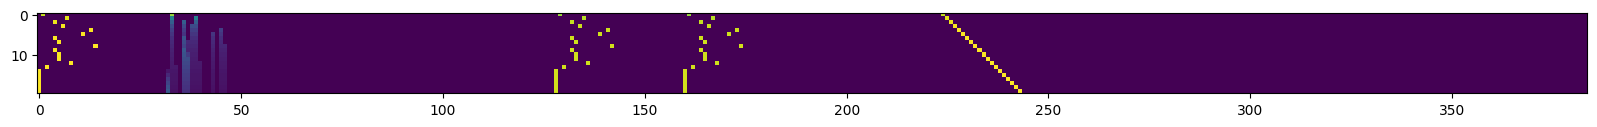

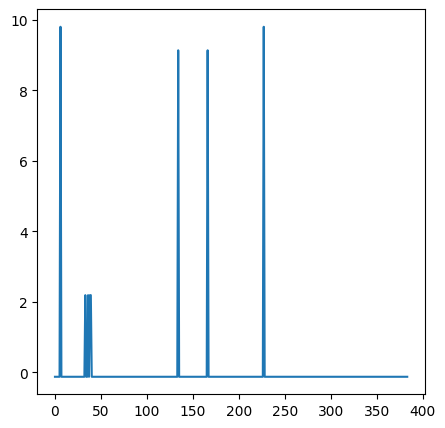

normalized MLP input^ tensor(-2.4835e-09) tensor(1.0001) tensor(9.9502) tensor(-0.1259)


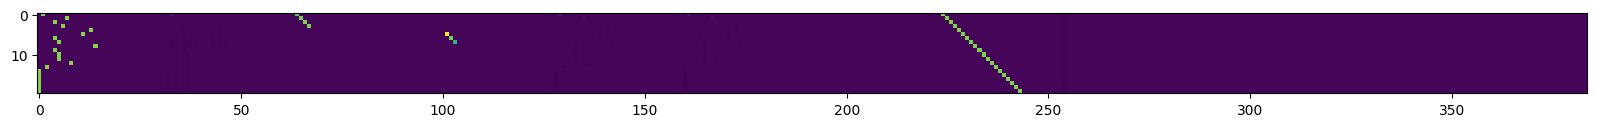

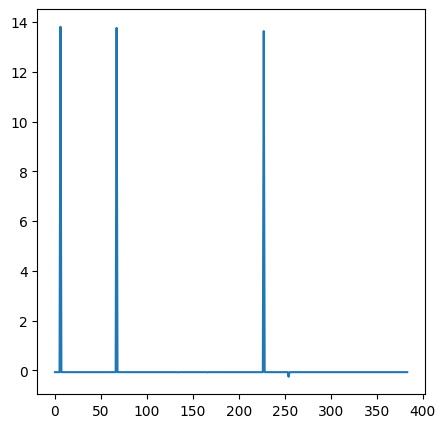

MLP+residual output^ tensor(0.0111) tensor(1.0760) tensor(17.0134) tensor(-0.2914)




==================== MLP ===================


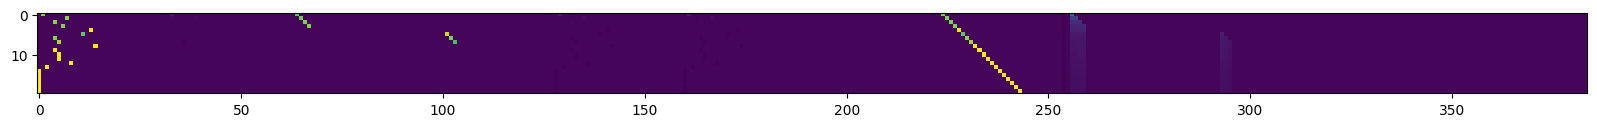

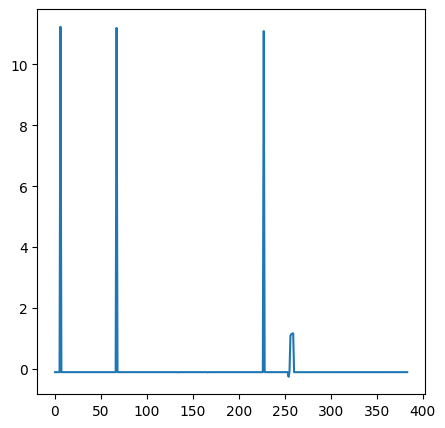

normalized MLP input^ tensor(-6.7055e-09) tensor(1.0001) tensor(13.8969) tensor(-0.2964)


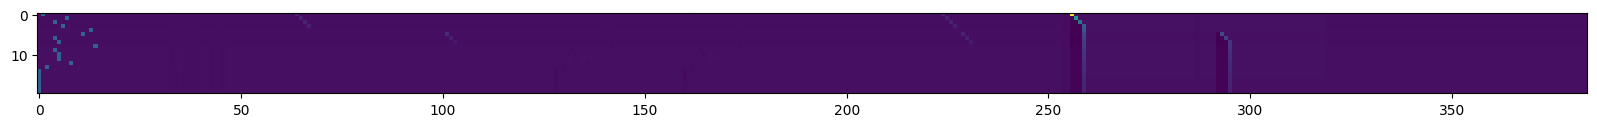

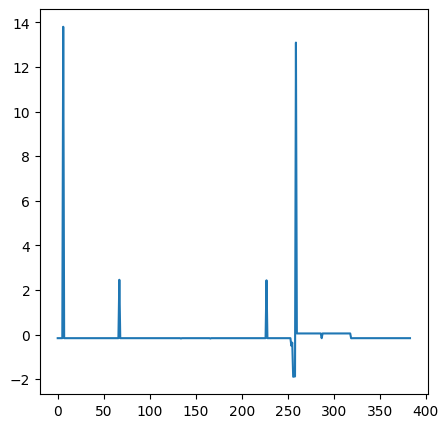

MLP+residual output^ tensor(-0.0679) tensor(1.0646) tensor(48.7546) tensor(-2.1378)




==================== MLP ===================


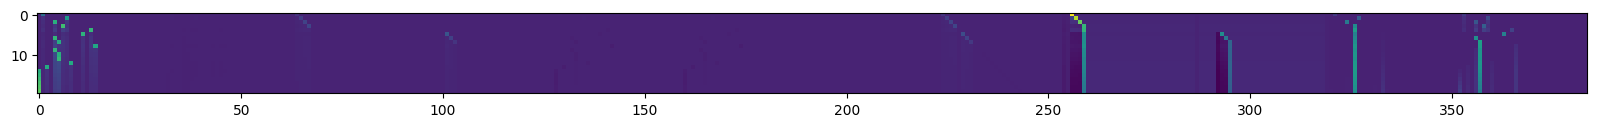

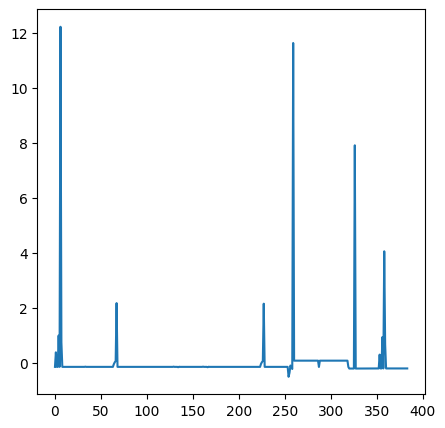

normalized MLP input^ tensor(0.) tensor(1.0001) tensor(18.6154) tensor(-2.2139)


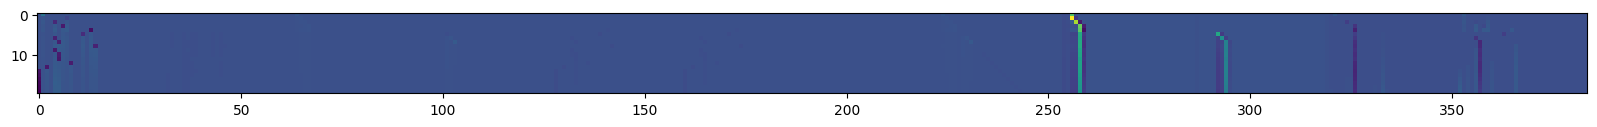

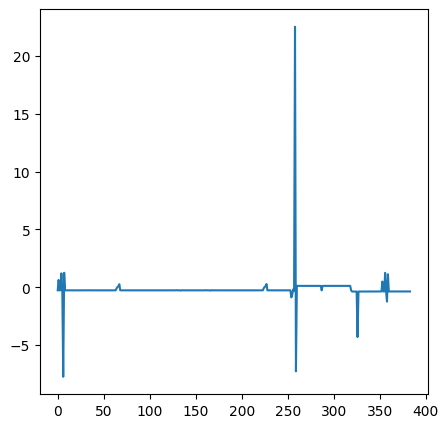

MLP+residual output^ tensor(-0.1703) tensor(1.1814) tensor(32.5648) tensor(-10.7796)




==================== MLP ===================


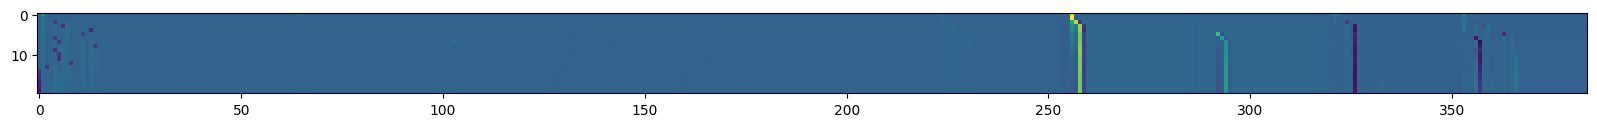

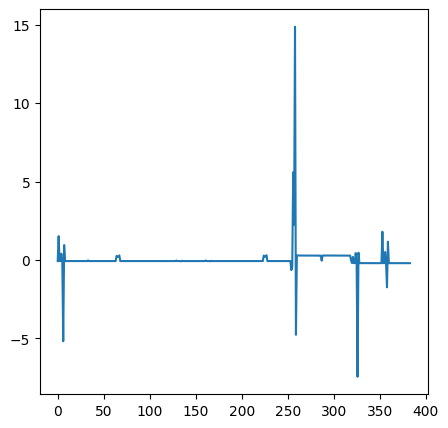

normalized MLP input^ tensor(7.3264e-09) tensor(1.0001) tensor(19.2430) tensor(-9.0102)


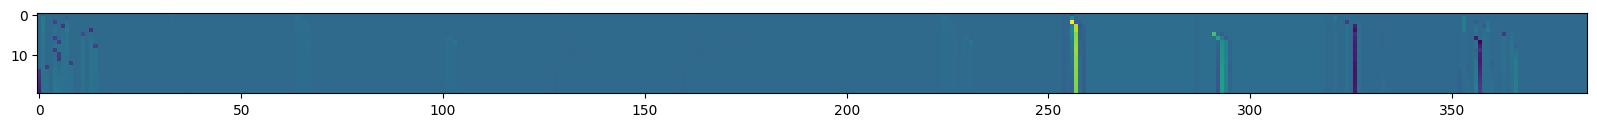

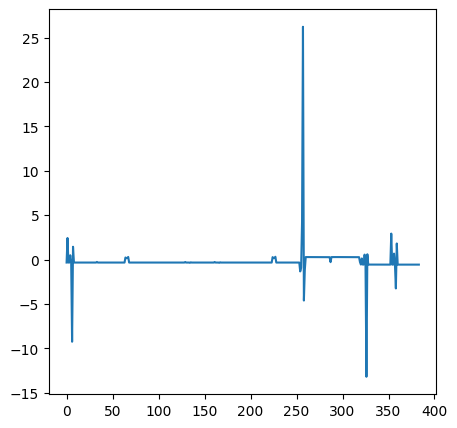

MLP+residual output^ tensor(-0.1899) tensor(1.6533) tensor(31.6016) tensor(-17.2158)






<IPython.core.display.Javascript object>

========== MLP BLOCK #1 =========
-2.4835269396561444e-09 1.0000628232955933 -0.1259084790945053 9.950177192687988


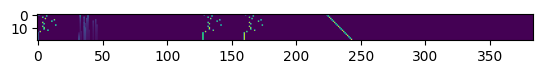

========== MLP BLOCK #2 =========
-6.705522359595761e-09 1.0000638961791992 -0.29635587334632874 13.896944046020508


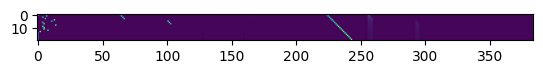

========== MLP BLOCK #3 =========
0.0 1.0000630617141724 -2.2138724327087402 18.615415573120117


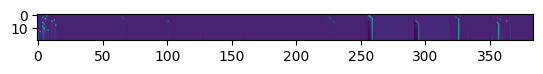

========== MLP BLOCK #4 =========
7.326404372065554e-09 1.0000636577606201 -9.010217666625977 19.243005752563477


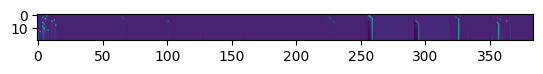

In [390]:
#import sys
#!{sys.executable} -m pip install bertviz

from bertviz import model_view

# create math input
batch_input_ids = torch.zeros([1,LLM_context_length],dtype=torch.long)
num1 = random.randint(0, 999)
num2 = random.randint(0, 999)
result = str(num1 + num2)
problem = f"{num1}+{num2}={result}"
tokenized = tokenizer.tokenize(problem, max_length=LLM_context_length)
batch_input_ids[0][:] = torch.tensor(tokenized)

labels = batch_input_ids.clone()
labels[labels==tokenizer.pad_token] = -1
labels = labels.roll(-1, dims=1)
labels[:,-1] = -1

# forward pass
model.eval()
with torch.no_grad():
    x, loss, att_map, hidden_states = model(idx=batch_input_ids, targets=labels) 
attention = att_map


a=tokenizer.detokenize(tokenized)
model_view(attention, a.replace('<s>', '_').replace('</s>', '_').replace('<pad>', '_'))


state = hidden_states


# INITIAL EMBEDDING - TOK+POS
l=0
print('========== MLP BLOCK #1 =========')
print(state[l][0].mean().item(), state[l][0].std().item(), state[l][0].min().item(), state[l][0].max().item())
plt.imshow(state[0][0])
plt.show()

l=1
print('========== MLP BLOCK #2 =========')
print(state[l][0].mean().item(), state[l][0].std().item(), state[l][0].min().item(), state[l][0].max().item())
plt.imshow(state[1][0])
plt.show()

l=2
print('========== MLP BLOCK #3 =========')
print(state[l][0].mean().item(), state[l][0].std().item(), state[l][0].min().item(), state[l][0].max().item())
plt.imshow(state[2][0])
plt.show()

l=3
print('========== MLP BLOCK #4 =========')
print(state[l][0].mean().item(), state[l][0].std().item(), state[l][0].min().item(), state[l][0].max().item())
plt.imshow(state[2][0])
plt.show()


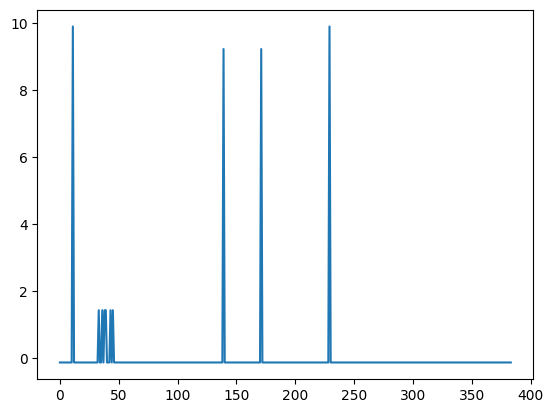

In [391]:
plt.plot(state[0][0][5])

In [392]:
l=0
t=1
print(state[l][0,t])
print(state[l][0].argmax(),state[l][0].max())

tensor([-0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,  9.5390,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207,  4.3845, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,  4.3845,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207, -0.1207,
        -0.1207, -0.1207, -0.1207, -0.12

tensor(32.2451)


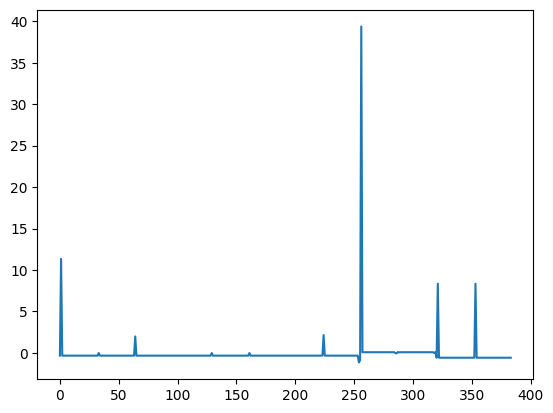

tensor(19.2430)


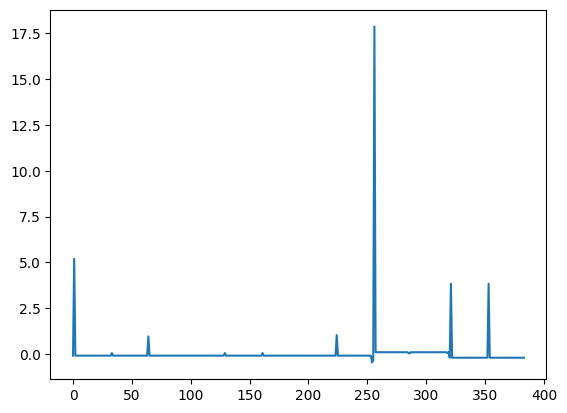

tensor(25.2935)


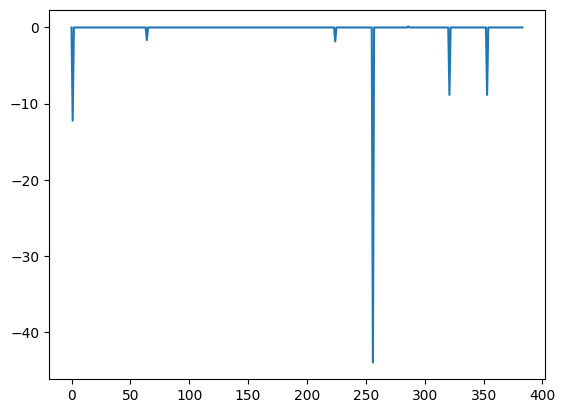

tensor(31.6016)


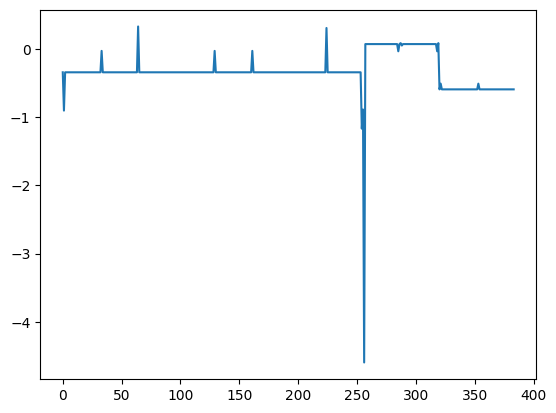

In [393]:
print(one[0,2].max())
plt.plot(one[0,0])
plt.show()

print(two.max())
plt.plot(two[0,0])
plt.show()

print(three.max())
plt.plot(three[0,0])
plt.show()

print(four.max())
plt.plot(four[0,0])
plt.show()
